# Nama: Nicolaus Reva Sagraha
# NIM: 225314097
# UAS: Sequence labelling dengan LSTM

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
print(tf.__version__)

2.18.0


# Membuat fungsi untuk melakukan preprocessing yang diperlukan

In [110]:
def load_vocab(vocab_path):
    """
    Membaca file vocab dan mengembalikan dictionary vocab.
    """
    vocab = {}
    with open(vocab_path, 'r', encoding='utf-8') as f:
        for idx, word in enumerate(f):
            word = word.strip()
            vocab[word] = idx + 1  # Mulai dari indeks 1
    vocab['<PAD>'] = 0  # Tambahkan token untuk padding
    vocab['<UNK>'] = len(vocab) + 1  # Token untuk kata tidak dikenal
    return vocab


def tokens_to_indices(tokens, vocab, unk_token='<UNK>'):
    """
    Mengubah list tokens menjadi list of indices berdasarkan vocab.
    """
    unk_index = vocab.get(unk_token, 0)
    return [vocab.get(token, unk_index) for token in tokens]


def pad_sequences_list(sequences, maxlen):
    """
    melakukan padding sequence 
    """
    return pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')


# Fungsi untuk preprocessing dataset
def preprocess_sequence_data(file_path, vocab, maxlen=50):
    """
    melakukan preprocessing data sequence 
    """
    sequences = []
    label_sequences = []

    with open(file_path, 'r', encoding='utf-8') as f:
        sentence = []
        labels = []
        for line in f:
            if line.strip() == "":
                # Simpan sentence dan label
                if sentence:
                    sequences.append([vocab.get(token, vocab['<UNK>']) for token in sentence])
                    label_sequences.append(labels)
                    sentence = []
                    labels = []
            else:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    token, label = parts
                    sentence.append(token)
                    labels.append(label)

    # Simpan kalimat terakhir jika ada
    if sentence:
        sequences.append([vocab.get(token, vocab['<UNK>']) for token in sentence])
        label_sequences.append(labels)

    # Padding sequences
    x_data = pad_sequences(sequences, maxlen=maxlen, padding='post', value=vocab['<PAD>'])

    # Label encoding
    label_encoder = LabelEncoder()
    flat_labels = [label for labels in label_sequences for label in labels]
    label_encoder.fit(flat_labels)
    y_data = [[label_encoder.transform([label])[0] for label in labels] for labels in label_sequences]
    y_data = pad_sequences(y_data, maxlen=maxlen, padding='post', value=0)

    return x_data, np.array(y_data), label_encoder


# Fungsi untuk membangun model
def build_model(vocab_size, embedding_dim, lstm_units, maxlen, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
        Bidirectional(LSTM(units=lstm_units, return_sequences=True)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Preprocessing Dataset, Membuat x dan y dari train, val dan test

In [111]:
vocab_path = 'vocab.txt'  # Path file vocab
vocab = load_vocab(vocab_path)
print("Vocabulary Size:", len(vocab))

Vocabulary Size: 20640


1. Membaca data train

In [112]:
file_path = 'train_preprocess.txt'  # Path ke file data
maxlen = 50  # Panjang maksimum sequence
x_train, y_train, label_encoder = preprocess_sequence_data(file_path, vocab, maxlen) # Preprocess data dan mengembalikan x_train, y_train, dan label_encoder

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("Label classes:", label_encoder.classes_)

x_train shape: (6720, 50)
y_train shape: (6720, 50)
Label classes: ['B-$$$' 'B-ADJ' 'B-ADK' 'B-ADV' 'B-ART' 'B-CCN' 'B-CSN' 'B-INT' 'B-KUA'
 'B-NEG' 'B-NNO' 'B-NNP' 'B-NUM' 'B-PAR' 'B-PPO' 'B-PRI' 'B-PRK' 'B-PRN'
 'B-PRR' 'B-SYM' 'B-UNS' 'B-VBE' 'B-VBI' 'B-VBL' 'B-VBP' 'B-VBT']


In [113]:
y_train

array([[10, 24, 10, ...,  0,  0,  0],
       [14, 14, 17, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       ...,
       [11, 24, 14, ...,  0,  0,  0],
       [10, 14, 12, ...,  0,  0,  0],
       [14, 10, 11, ...,  0,  0,  0]], dtype=int32)

2. Membaca data val

In [114]:
file_path = 'valid_preprocess.txt'  # Path ke file data
maxlen = 50  # Panjang maksimum sequence
x_val, y_val, label_encoder_val = preprocess_sequence_data(file_path, vocab, maxlen) # Preprocess data dan mengembalikan x_val, y_val, dan label_encoder

print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("Label classes:", label_encoder_val.classes_)

x_val shape: (840, 50)
y_val shape: (840, 50)
Label classes: ['B-$$$' 'B-ADJ' 'B-ADK' 'B-ADV' 'B-ART' 'B-CCN' 'B-CSN' 'B-INT' 'B-KUA'
 'B-NEG' 'B-NNO' 'B-NNP' 'B-NUM' 'B-PAR' 'B-PPO' 'B-PRI' 'B-PRK' 'B-PRN'
 'B-PRR' 'B-SYM' 'B-UNS' 'B-VBE' 'B-VBI' 'B-VBL' 'B-VBP' 'B-VBT']


In [115]:
file_path = 'test_preprocess.txt'
maxlen = 50
x_test, y_test, label_encoder_test = preprocess_sequence_data(file_path, vocab, maxlen) # Preprocess data dan mengembalikan x_test, y_test, dan label_encoder

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("Label classes:", label_encoder_test.classes_)

x_test shape: (840, 50)
y_test shape: (840, 50)
Label classes: ['B-$$$' 'B-ADJ' 'B-ADK' 'B-ADV' 'B-ART' 'B-CCN' 'B-CSN' 'B-INT' 'B-KUA'
 'B-NEG' 'B-NNO' 'B-NNP' 'B-NUM' 'B-PAR' 'B-PPO' 'B-PRI' 'B-PRK' 'B-PRN'
 'B-PRR' 'B-SYM' 'B-UNS' 'B-VBE' 'B-VBI' 'B-VBL' 'B-VBP' 'B-VBT']


In [116]:
y_val

array([[19, 14, 10, ...,  0,  0,  0],
       [10, 10, 11, ...,  0,  0,  0],
       [10, 11,  4, ...,  0,  0,  0],
       ...,
       [ 5, 14, 10, ...,  0,  0,  0],
       [11, 25, 14, ...,  0,  0,  0],
       [14, 10, 10, ...,  0,  0,  0]], dtype=int32)

# Melatih model menggunakan training data

In [117]:
y_train = y_train[..., np.newaxis]  #mengubah dimensi y_train agar sesuai dengan input model

# Parameter Model
vocab_size = len(vocab) + 1  # Tambahkan 1 untuk padding token
embedding_dim = 64           # Dimensi embedding
lstm_units = 128            # Jumlah LSTM units
maxlen = 50                 # Panjang maksimum sequence
num_classes = len(label_encoder.classes_) # Jumlah kelas

# Bangun Model
model = build_model(vocab_size, embedding_dim, lstm_units, maxlen, num_classes)

# Latih Model
history = model.fit(
    x_train, y_train,
    validation_split=0.1,  # Gunakan 10% data untuk validasi
    batch_size=32,
    epochs=5
)

Epoch 1/5


C:\Users\nicol\virtualenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6277 - loss: 1.4104 - val_accuracy: 0.8420 - val_loss: 0.5005
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8979 - loss: 0.3656 - val_accuracy: 0.9605 - val_loss: 0.1491
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9772 - loss: 0.1002 - val_accuracy: 0.9719 - val_loss: 0.0973
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9879 - loss: 0.0514 - val_accuracy: 0.9746 - val_loss: 0.0853
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9906 - loss: 0.0367 - val_accuracy: 0.9743 - val_loss: 0.0862


In [118]:
y_val = y_val[..., np.newaxis]                  #mengubah dimensi y_val agar sesuai dengan input model

loss, accuracy = model.evaluate(x_val, y_val)   # Evaluasi model menggunakan data validasi
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9731 - loss: 0.0912
Validation Loss: 0.09303083270788193
Validation Accuracy: 0.9720476865768433


In [119]:
y_pred = model.predict(x_test)                  # Melakukan prediksi menggunakan data test
y_pred_classes = np.argmax(y_pred, axis=-1)     # Mengambil kelas dengan nilai probabilitas tertinggi

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


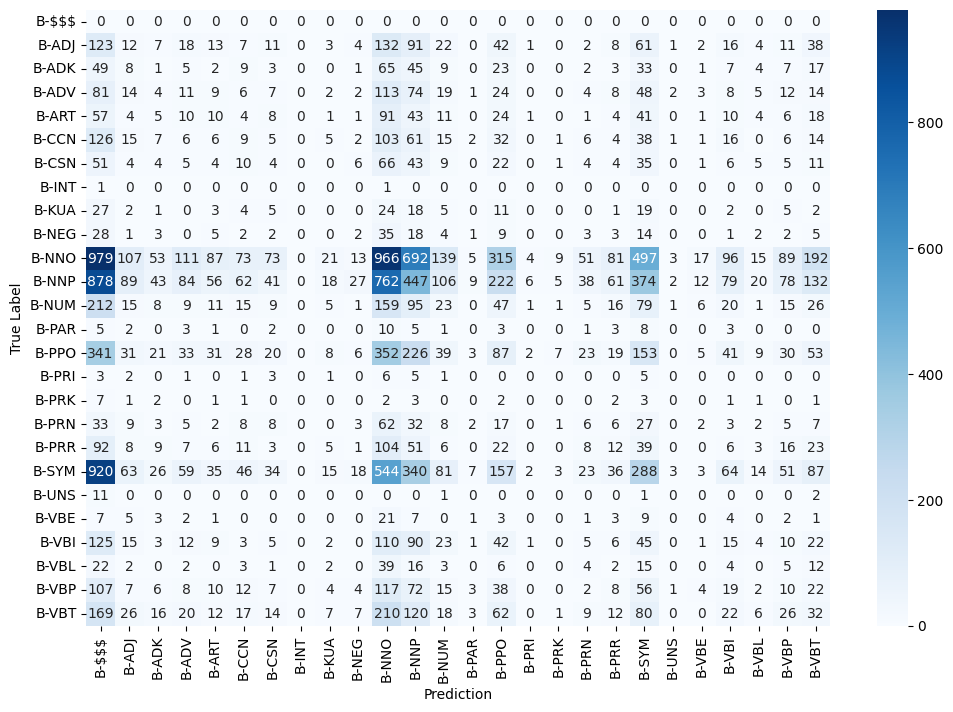

In [120]:
y_true_flat = []                                            # Mengubah y_test dan y_pred_classes menjadi list flat
y_pred_flat = []

for true_seq, pred_seq in zip(y_val, y_pred_classes):
    for true_label, pred_label in zip(true_seq, pred_seq):
        if true_label != 0:                                 # Skip token padding (0)
            y_true_flat.append(true_label)                  # menggabungkan label sebenarnya dan prediksi
            y_pred_flat.append(pred_label)

conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)    # Membuat confusion matrix
plt.figure(figsize=(12, 8))                                 # Membuat canvas dengan ukuran 12 x 8
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.show()                                                  # Menampilkan confusion matrix

In [121]:
print(classification_report(y_true_flat, y_pred_flat, target_names=label_encoder.classes_)) # Menampilkan classification report

              precision    recall  f1-score   support

       B-$$$       0.00      0.00      0.00         0
       B-ADJ       0.03      0.02      0.02       629
       B-ADK       0.00      0.00      0.00       294
       B-ADV       0.03      0.02      0.02       471
       B-ART       0.03      0.03      0.03       355
       B-CCN       0.03      0.02      0.02       481
       B-CSN       0.02      0.01      0.01       300
       B-INT       0.00      0.00      0.00         2
       B-KUA       0.00      0.00      0.00       129
       B-NEG       0.02      0.01      0.02       140
       B-NNO       0.24      0.21      0.22      4688
       B-NNP       0.17      0.12      0.14      3651
       B-NUM       0.04      0.03      0.03       780
       B-PAR       0.00      0.00      0.00        47
       B-PPO       0.07      0.06      0.06      1568
       B-PRI       0.00      0.00      0.00        28
       B-PRK       0.00      0.00      0.00        27
       B-PRN       0.03    

C:\Users\nicol\virtualenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\virtualenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\virtualenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\virtualenv\Lib\site-packages\s